In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

In [3]:
# 이미지 데이터 경로 설정
train_data_dir = 'face_sample'  # 폴더 경로 설정 (350장 테스트)
input_shape = (224, 224)
batch_size = 32
num_classes = 7  # 클래스 개수에 맞게 설정

# 데이터셋 생성
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,  # 각 픽셀 값을 0에서 1 사이로 변환
)

train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical' 
)

Found 350 images belonging to 7 classes.


In [6]:
def DenseNet(x):
    # input = 224 x 224 x 3
    k = 32  # Grow Rate
    compression = 0.5   # compression factor

    # 1. Convolution
    # 입력 이미지에 7x7 크기의 필터를 사용하는 Convolution 레이어를 적용
    x = layers.Conv2D(k * 2, (7, 7), strides=2, padding='same', input_shape=(224, 224, 3))(x)    # 112x112x64
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 2. Pooling
    # 이미지 내의 중요한 특성을 보존하면서 크기를 wnfdla
    x = layers.MaxPool2D((3, 3), 2, padding='same')(x)  # 56x56x64

    # 3. Dense Block (1)
    # Convolution 레이어를 연속으로 쌓아서 Dense Block을 만듦
    for i in range(6) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)    # 56x56x128
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)  # 56x56x32
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])  # 96 -> 128 -> 160 -> 192 -> 224 -> 256

    # 4. Transition Layer (1)
    # Dense Block 이후에 위치하며, 채널 수를 줄이기 위한 역할을 함
    current_shape = int(x.shape[-1]) # 56x56x256
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 28x28

    # 5. Dense Block (2)
    for i in range(12) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 6. Transition Layer (2)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 14x14

    # 7. Dense Block (3)
    for i in range(24) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 8. Transition Layer (3)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 7x7

    # 9. Dense Block (4)
    for i in range(16) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 10. Classification Layer
    x = layers.GlobalAveragePooling2D()(x)
    # classes = 7 (softmax)
    x = layers.Dense(7, activation='softmax')(x)

    return x

In [7]:
# 모델 생성
input_layer = layers.Input(shape=(*input_shape, 3), dtype='float32', name='input')
output_layer = DenseNet(input_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [8]:
# 클래스 개수 설정
num_classes = 7

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='categorical_crossentropy',  # 다중 클래스 분류용 함수
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

 chNormalization)                                                                                 
                                                                                                  
 activation_3 (Activation)   (None, 56, 56, 128)          0         ['batch_normalization_3[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 56, 56, 32)           36896     ['activation_3[0][0]']        
                                                                                                  
 batch_normalization_4 (Bat  (None, 56, 56, 32)           128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activatio

In [9]:
# 모델 학습
epochs = 10
model.fit(train_generator, epochs=epochs)

Epoch 1/10
11/11 [==============================] - 124s 9s/step - loss: 2.0375 - acc: 0.1257
Epoch 2/10
11/11 [==============================] - 102s 9s/step - loss: 1.9988 - acc: 0.1343
Epoch 3/10
11/11 [==============================] - 99s 9s/step - loss: 1.9673 - acc: 0.1314
Epoch 4/10
11/11 [==============================] - 98s 9s/step - loss: 1.9359 - acc: 0.1543
Epoch 5/10
11/11 [==============================] - 98s 9s/step - loss: 1.9283 - acc: 0.1686
Epoch 6/10
11/11 [==============================] - 99s 9s/step - loss: 1.9265 - acc: 0.1629
Epoch 7/10
11/11 [==============================] - 98s 9s/step - loss: 1.9158 - acc: 0.1800
Epoch 8/10
11/11 [==============================] - 98s 9s/step - loss: 1.9083 - acc: 0.1886
Epoch 9/10
11/11 [==============================] - 98s 9s/step - loss: 1.9023 - acc: 0.1829
Epoch 10/10
11/11 [==============================] - 99s 9s/step - loss: 1.9052 - acc: 0.2029


In [14]:
# 클래스 이름과 인덱스 매핑 출력
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [19]:
history = model.fit(train_generator, epochs=epochs)

Epoch 1/10
11/11 [==============================] - 103s 9s/step - loss: 1.8860 - acc: 0.2257
Epoch 2/10
11/11 [==============================] - 105s 9s/step - loss: 1.8858 - acc: 0.2114
Epoch 3/10
11/11 [==============================] - 104s 9s/step - loss: 1.8794 - acc: 0.2229
Epoch 4/10
11/11 [==============================] - 100s 9s/step - loss: 1.8830 - acc: 0.2029
Epoch 5/10
11/11 [==============================] - 104s 9s/step - loss: 1.8699 - acc: 0.2371
Epoch 6/10
11/11 [==============================] - 102s 9s/step - loss: 1.8581 - acc: 0.2571
Epoch 7/10
11/11 [==============================] - 103s 9s/step - loss: 1.8524 - acc: 0.2514
Epoch 8/10
11/11 [==============================] - 100s 9s/step - loss: 1.8527 - acc: 0.3200
Epoch 9/10
11/11 [==============================] - 99s 9s/step - loss: 1.8521 - acc: 0.2686
Epoch 10/10
11/11 [==============================] - 98s 9s/step - loss: 1.8407 - acc: 0.2829


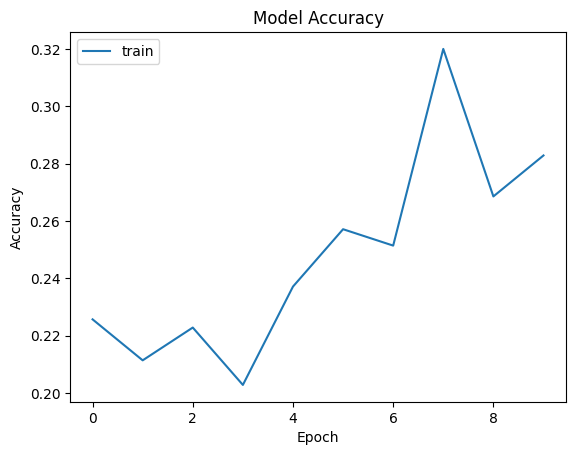

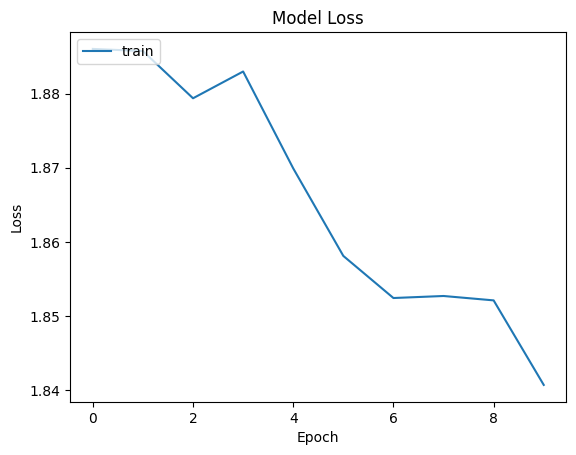

In [20]:
# Accuracy 그래프
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

# Loss 그래프
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()